In [1]:
import generator
import model
import os
import matplotlib.pyplot as plt


### Loss functions and Embedding size

In [2]:
import pickle
import torch
import fastbook
from fastbook import *
from fastai.collab import *
from fastai.tabular.all import *
from fastai.losses import *
import torch.nn as nn


def get_small_emb_sz(dls_df, n_bits=None):
    emb = get_emb_sz(dls_df)   # corresponds to number of nodes in each column
    print("recommended emb size", emb)
    emb = max(emb,key=lambda x:x[0])
    if n_bits == None:
        n_bits = emb[1]
    print("\tusing emb size:", (emb[0], n_bits))
    return [(emb[0], n_bits)]


def MRELoss(inp, targ) -> Tensor:
    inp = torch.flatten(inp).float()
    targ = torch.flatten(targ).float()
    nom = torch.nn.functional.l1_loss(inp, targ)
    noo = torch.Tensor([0]).repeat(targ.size(0)).to(device)
    denom = torch.nn.functional.l1_loss(noo, targ)
    loss = (nom / denom).mean()
    return loss


def CombineLoss(inp, targ) -> Tensor:
    mse_loss = MSELossFlat()
    loss_1 = mse_loss(inp, targ)

    loss_2 = MRELoss(inp, targ)

    return alpha * loss_1 + (1 - alpha) * loss_2

/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# learn.recorder()from fastai2.imports import *
# from fastai2.torch_core import *
# from fastai2.learner import *
# call as: learn.recorder.plot_metrics()
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()
    

In [4]:
def create_model(dataset, loss_function, n_bits, valid_pct, savepath):
    if (not os.path.exists(savepath)):
        os.makedirs(savepath)

    data = np.array(dataset)
    df = pd.DataFrame(data, columns=['src', 'dst', 'label'])
    dls_df = CollabDataLoaders.from_df(df, bs=64, valid_pct=valid_pct)
    
    embs_sz = get_small_emb_sz(dls_df, n_bits)
    # multiply number of nodes by 2. max distance cannot be larger than this
    # this represents the max width of an individual graph
    max_value = df.label.max() * 2
    # print("max value is", max_value, "gotten by max label:", df.label.max(), "* embedding matrix size: ", embs_sz[0][0])
    trainer = model.CollabNN(*embs_sz, y_range=(0, max_value))

    learn = Learner(dls_df, trainer, loss_func=loss_function, path=savepath, metrics=[mse, mae, MRELoss])
    
    return learn, df

def train_model(dataset, num_epochs, loss_function, n_bits=None, valid_pct=0.2, savepath="save/default/"):

    learn, df = create_model(dataset, loss_function, n_bits, valid_pct, savepath)

    SaveModelCallback(with_opt=True)
    learn.remove_cb(ProgressCallback) #remove (uncomment) progresscallback if running from terminal

    learn.fit_one_cycle(n_epoch=num_epochs, lr_max=5e-3, wd=0.01),
    #  cbs=[EarlyStoppingCallback(monitor='train_loss', min_delta=0.00001, patience=50)])  #ShowGraphCallback(), 
    
    allnodes = set(df.src).union(set(df.dst))
    embs = learn.model.save_embeddings(Tensor(list(allnodes)).to(device).int())

    with open(savepath + "embeddings.pkl", "wb") as outfile:
        pickle.dump(embs, outfile)
    
    learn.export()
    return learn

### get the datasets

In [5]:
def get_cycles_dataset(lg_N, train_pct=0.8):
    cy_datapath =  'save/cycle/data/log_' + str(lg_N) + '_data'

    if os.path.isfile(cy_datapath):
        cycles_dataset = generator.load_dataset_from_file(cy_datapath)
        print("similar data gotten before... retrieved data")
    else:
        cycles_dataset = generator.generate_cycles_dataset(lg_N)
        generator.save_dataset_to_file(cycles_dataset, cy_datapath)
    cycles_dataset = np.array(cycles_dataset)
    np.random.shuffle(cycles_dataset)
    cycles_trainset, cycles_testset = cycles_dataset[:int(train_pct*len(cycles_dataset)),:], cycles_dataset[int(train_pct*len(cycles_dataset)):,:]
    
    return cycles_trainset, cycles_testset

In [6]:
def get_graphs_dataset(train_pct=0.8, real_graph_paths=None):
    if real_graph_paths == None:
        real_graph_paths = [
                            "/jumbo/lisp/ike/code/DistanceLabelling/datasets/ENZYMES_g1/ENZYMES_g1.edges",
                            "/jumbo/lisp/ike/code/DistanceLabelling/datasets/ENZYMES_g1/ENZYMES_g1.edges", 
                           "/jumbo/lisp/ike/code/DistanceLabelling/datasets/ENZYMES_g118/ENZYMES_g118.edges"
                           ]
    gr_datapath =  'save/graph/data/ngraphs_' + str(len(real_graph_paths)) + '_data'

    if os.path.isfile(gr_datapath):
        graphs_dataset = generator.load_dataset_from_file(gr_datapath)
        print("similar data gotten before... retrieved data")
    else:
        graphs_dataset = generator.generate_real_graphs_dataset(real_graph_paths)
        generator.save_dataset_to_file(graphs_dataset, gr_datapath)
    graphs_dataset = np.array(graphs_dataset)
    np.random.shuffle(graphs_dataset)
    graphs_trainset, graphs_testset = graphs_dataset[:int(train_pct*len(graphs_dataset)),:], graphs_dataset[int(train_pct*len(graphs_dataset)):,:]
    
    return graphs_trainset, graphs_testset

In [7]:
def get_trees_dataset(lg_N, train_pct=0.8):
    tr_datapath =  'save/tree/data/log_' + str(lg_N) + '_data'

    if os.path.isfile(tr_datapath):
        trees_dataset = generator.load_dataset_from_file(tr_datapath)
        print("similar data gotten before... retrieved data")
    else:
        trees_dataset = generator.generate_trees_dataset(2**lg_N)
        generator.save_dataset_to_file(trees_dataset, tr_datapath)

    trees_dataset = np.array(trees_dataset)
    np.random.shuffle(trees_dataset)
    trees_trainset, trees_testset = trees_dataset[:int(train_pct*len(trees_dataset)),:], trees_dataset[int(train_pct*len(trees_dataset)):,:]

    return trees_trainset, trees_testset

In [8]:
def get_cycle_model(cycles_dataset, alpha, num_epochs, n_bits, loss_function, lg_N, train_pct):
    # create and train on cycles
    split = train_pct*100
    cy_savepath = 'save/cycle/'+str(n_bits) + 'bits/split_' + str(
        split) + '_' + str(alpha) + '_' + str(lg_N) + '_' + str(num_epochs) + '/'

    saved = cy_savepath+"export.pkl" 
    if os.path.isfile(saved):
        cycle_model = load_learner(saved, cpu=False)  # learn.load('model')
        print("exact model trained before... retrieved model")
    else:
        cycle_model = train_model(cycles_dataset, num_epochs, loss_function, n_bits=n_bits, savepath=cy_savepath)
        cycle_model.recorder.plot_metrics()
    return cycle_model

In [9]:
def get_tree_model(trees_dataset, alpha, num_epochs, n_bits, loss_function, lg_N, train_pct):
    # create and train on trees
    split = train_pct*100
    tr_savepath = 'save/tree/'+str(n_bits) + 'bits/split_' + str(
        split) + '_' + str(alpha) + '_' + str(lg_N) + '_' + str(num_epochs) + '/'
    saved = tr_savepath+"export.pkl"  # "models/model.pth"
    if os.path.isfile(saved):
        tree_model = load_learner(saved, cpu=False)  # learn.load('model')
        print("exact model trained before... retrieved model")
    else:
        tree_model = train_model(trees_dataset, num_epochs, loss_function, n_bits=n_bits, savepath=tr_savepath)
        print(tree_model.model.node_to_emb)
        tree_model.recorder.plot_metrics()
        
    return tree_model

In [10]:
def get_graph_model(graphs_dataset, alpha, num_epochs, n_bits, loss_function, train_pct):
    split = train_pct*100
    # create and train on real graphs
    gr_savepath = 'save/graph/' +str(n_bits) + 'bits/split_' + str(split) + '_' + str(alpha) + '_' + str(num_epochs) + '/'
    saved = gr_savepath+"export.pkl"  # "models/model.pth"
    if os.path.isfile(saved):
        graph_model = load_learner(saved, cpu=False)  # learn.load('model')
        print("exact model trained before... retrieved model")
    else:
        graph_model = train_model(graphs_dataset, num_epochs, loss_function, n_bits=n_bits, savepath=gr_savepath)
        graph_model.recorder.plot_metrics()
    return graph_model

In [11]:
def plot_bits_to_loss(max_bits, trainloss, model_type, alpha, num_epochs, train_pct, eval_loss, lossname, lg_N=4):
    losses = []
    if model_type.lower() == 'cycle':
      trainset, testset = get_cycles_dataset(lg_N, train_pct)
    elif model_type.lower() == 'tree':
      trainset, testset = get_trees_dataset(lg_N, train_pct)
    elif model_type.lower() == 'graph':
      trainset, testset = get_graphs_dataset(train_pct)
    else:
      print("incorrect input")
      return
    for n_bits in range(1, max_bits):
      print("using", n_bits, "bits")
      if model_type.lower() == 'cycle':
        model = get_cycle_model(
            trainset, alpha, num_epochs, n_bits, trainloss, lg_N, train_pct)
      elif model_type.lower() == 'tree':
        model = get_tree_model(trainset, alpha, num_epochs, n_bits, trainloss, lg_N, train_pct)
      elif model_type.lower() == 'graph':
        model = get_graph_model(trainset, alpha, num_epochs, n_bits, trainloss, train_pct)
      else:
        print("incorrect input")
        return

      print(model.n_bits)
      tst_data, y_targ = torch.IntTensor(testset[:, :2]).to(device), torch.IntTensor(np.array(testset)[:, 2]).to(device)
      preds = model.model(tst_data)
      losses.append(float(eval_loss(preds, y_targ)))

    plt.plot(range(1, max_bits), losses)
    savepath = 'save/plot/'+lossname+'/' + model_type + '_' + str(alpha) + '_' + str(max_bits) + '.png'
    os.makedirs(os.path.dirname(savepath), exist_ok=True)
    plt.title(lossname + ' loss for ' + model_type + ' model')
    plt.savefig(savepath)
    plt.show()
    print(losses)

In [12]:
# shared hyperparams
num_epochs = 280
alpha = 0.1
loss_function = CombineLoss
# n_bits = 4
lg_N = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_pct = 0.2
eval_loss = CombineLoss


# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


using 1 bits
recommended emb size [(494, 52), (492, 51)]
	using emb size: (494, 1)
[0, 10.591422080993652, 7.925280570983887, 60.2061882019043, 7.216843605041504, 2.1162917613983154, '00:00']
[1, 6.653969764709473, 4.33061408996582, 30.05400276184082, 5.031391620635986, 1.472459316253662, '00:00']
[2, 4.046741008758545, 2.6577799320220947, 16.933399200439453, 3.6778676509857178, 1.0716001987457275, '00:00']
[3, 2.6633589267730713, 1.9258184432983398, 11.774039268493652, 2.871659994125366, 0.831571638584137, '00:00']
[4, 1.9984861612319946, 1.6404062509536743, 10.082244873046875, 2.4390296936035156, 0.7024242281913757, '00:00']
[5, 1.7184103727340698, 1.5541486740112305, 9.751070976257324, 2.242435932159424, 0.6433795094490051, '00:00']
[6, 1.602725863456726, 1.5401030778884888, 9.74541187286377, 2.192579746246338, 0.6284025311470032, '00:00']
[7, 1.5855696201324463, 1.5385690927505493, 9.757315635681152, 2.1822962760925293, 0.6253750920295715, '00:00']
[8, 1.5722192525863647, 1.5403696

[73, 1.566894769668579, 1.5480308532714844, 9.83508014678955, 2.1896867752075195, 0.6272478699684143, '00:00']
[74, 1.5583033561706543, 1.555721402168274, 10.044601440429688, 2.142413854598999, 0.6125125288963318, '00:00']
[75, 1.6098694801330566, 1.5569812059402466, 10.049734115600586, 2.1452765464782715, 0.6133419275283813, '00:00']
[76, 1.5916441679000854, 1.541823387145996, 9.764978408813477, 2.1919898986816406, 0.6281391978263855, '00:00']
[77, 1.5927834510803223, 1.544667363166809, 9.855303764343262, 2.169041395187378, 0.6212632656097412, '00:00']
[78, 1.601375699043274, 1.543405294418335, 9.819786071777344, 2.1775355339050293, 0.623807430267334, '00:00']
[79, 1.5952043533325195, 1.5418531894683838, 9.810229301452637, 2.175145387649536, 0.6231446266174316, '00:00']
[80, 1.6111053228378296, 1.5695359706878662, 10.09035873413086, 2.1762759685516357, 0.6227779984474182, '00:00']
[81, 1.5887058973312378, 1.5521726608276367, 9.875350952148438, 2.189603328704834, 0.6273751258850098, '0

[146, 1.574924111366272, 1.545828104019165, 9.915692329406738, 2.1517157554626465, 0.6158434152603149, '00:00']
[147, 1.5571736097335815, 1.5423561334609985, 9.789581298828125, 2.185262680053711, 0.6259977221488953, '00:00']
[148, 1.591939091682434, 1.5508031845092773, 9.791977882385254, 2.213409185409546, 0.6351171135902405, '00:00']
[149, 1.5953477621078491, 1.5506047010421753, 9.950934410095215, 2.1566660404205322, 0.6172347068786621, '00:00']
[150, 1.5743293762207031, 1.5490731000900269, 9.935114860534668, 2.1564016342163086, 0.6172906756401062, '00:00']
[151, 1.587361454963684, 1.5453033447265625, 9.756041526794434, 2.2069778442382812, 0.6329991221427917, '00:00']
[152, 1.5878167152404785, 1.5425646305084229, 9.79865837097168, 2.1824100017547607, 0.6252210140228271, '00:00']
[153, 1.586751937866211, 1.5486066341400146, 9.95070743560791, 2.150315284729004, 0.615039587020874, '00:00']
[154, 1.5841282606124878, 1.5448681116104126, 9.91425609588623, 2.1495118141174316, 0.6149360537528

[219, 1.5813217163085938, 1.5434056520462036, 9.862876892089844, 2.162095308303833, 0.6190201044082642, '00:00']
[220, 1.5628432035446167, 1.5430254936218262, 9.845686912536621, 2.166728973388672, 0.6205076575279236, '00:00']
[221, 1.5662120580673218, 1.5446958541870117, 9.879016876220703, 2.1610703468322754, 0.6186603307723999, '00:00']
[222, 1.56981360912323, 1.543216347694397, 9.86935806274414, 2.1588315963745117, 0.6180895566940308, '00:00']
[223, 1.582883358001709, 1.5434365272521973, 9.804816246032715, 2.1828114986419678, 0.6255055069923401, '00:00']
[224, 1.55959153175354, 1.5429445505142212, 9.852088928222656, 2.1641244888305664, 0.6197062730789185, '00:00']
[225, 1.5368893146514893, 1.5450890064239502, 9.899810791015625, 2.154632091522217, 0.6167866587638855, '00:00']
[226, 1.5716817378997803, 1.542985439300537, 9.863615989685059, 2.160127878189087, 0.6184706687927246, '00:00']
[227, 1.5869333744049072, 1.542815089225769, 9.845231056213379, 2.1662135124206543, 0.62032461166381

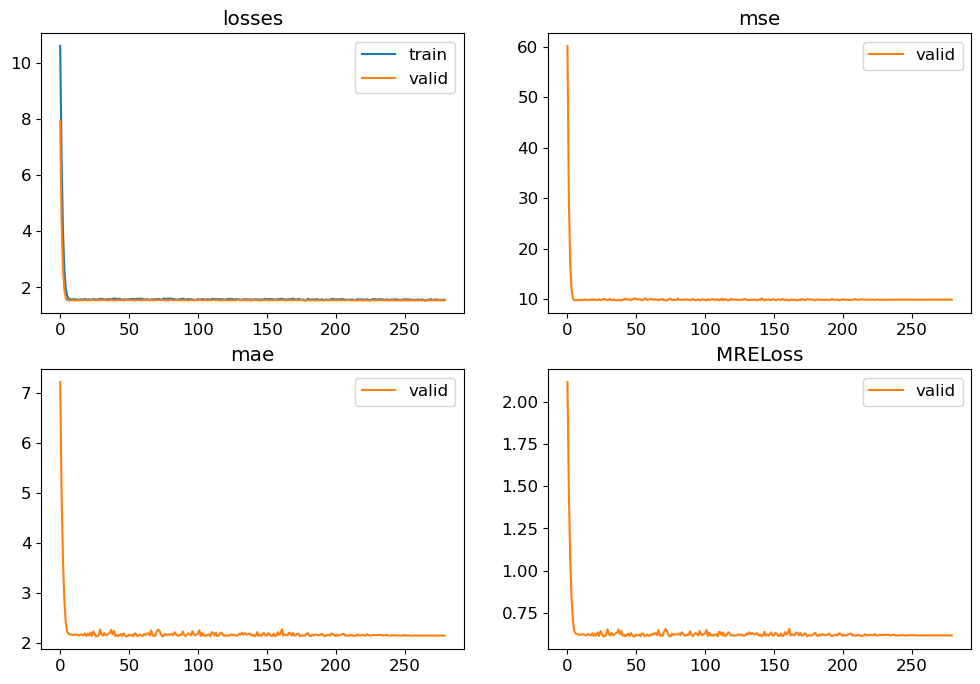

1
using 2 bits
recommended emb size [(494, 52), (492, 51)]
	using emb size: (494, 2)
[0, 12.438307762145996, 9.625814437866211, 75.18840026855469, 8.063843727111816, 2.3410823345184326, '00:00']
[1, 7.911014556884766, 5.37376594543457, 38.768333435058594, 5.733839988708496, 1.6632581949234009, '00:00']
[2, 4.793792247772217, 3.218613862991333, 21.196182250976562, 4.21907377243042, 1.2211062908172607, '00:00']
[3, 3.010007381439209, 2.221320867538452, 13.80846881866455, 3.2369401454925537, 0.9338598847389221, '00:00']
[4, 2.11529803276062, 1.8173578977584839, 11.240046501159668, 2.6787548065185547, 0.770392656326294, '00:00']
[5, 1.755725383758545, 1.6816458702087402, 10.629487991333008, 2.3975822925567627, 0.6874411702156067, '00:00']
[6, 1.6209235191345215, 1.6541919708251953, 10.595789909362793, 2.3071343898773193, 0.6606811285018921, '00:00']
[7, 1.5622750520706177, 1.6475549936294556, 10.595902442932129, 2.281982898712158, 0.6532939672470093, '00:00']
[8, 1.5453131198883057, 1.6423

[73, 1.5688111782073975, 1.634346842765808, 10.42409896850586, 2.2963483333587646, 0.657707691192627, '00:00']
[74, 1.5537008047103882, 1.6597874164581299, 10.77029800415039, 2.2638490200042725, 0.647508442401886, '00:00']
[75, 1.5468274354934692, 1.6353768110275269, 10.504936218261719, 2.270667314529419, 0.6498704552650452, '00:00']
[76, 1.560536503791809, 1.6439884901046753, 10.418510437011719, 2.333113431930542, 0.6690414547920227, '00:00']
[77, 1.579437494277954, 1.6377415657043457, 10.562492370605469, 2.2576181888580322, 0.6461026072502136, '00:00']
[78, 1.5584932565689087, 1.6335365772247314, 10.489860534667969, 2.2682392597198486, 0.6495006680488586, '00:00']
[79, 1.5498018264770508, 1.6403162479400635, 10.461286544799805, 2.304338216781616, 0.6602081656455994, '00:00']
[80, 1.5693117380142212, 1.6361404657363892, 10.526796340942383, 2.2653121948242188, 0.6482899188995361, '00:00']
[81, 1.5642908811569214, 1.638335943222046, 10.655624389648438, 2.2254810333251953, 0.636414825916

[146, 1.543013095855713, 1.6340272426605225, 10.465841293334961, 2.2798664569854736, 0.6527145504951477, '00:00']
[147, 1.5424511432647705, 1.6349414587020874, 10.468809127807617, 2.281700372695923, 0.6534005999565125, '00:00']
[148, 1.5616406202316284, 1.6324052810668945, 10.544746398925781, 2.244208574295044, 0.6421453952789307, '00:00']
[149, 1.5374444723129272, 1.6327797174453735, 10.548759460449219, 2.243981122970581, 0.6421152353286743, '00:00']
[150, 1.5322552919387817, 1.6321903467178345, 10.540233612060547, 2.2448415756225586, 0.6424077749252319, '00:00']
[151, 1.547418475151062, 1.6363193988800049, 10.532307624816895, 2.263230562210083, 0.6478763222694397, '00:00']
[152, 1.5387154817581177, 1.6333539485931396, 10.572663307189941, 2.236867666244507, 0.6400974988937378, '00:00']
[153, 1.5212764739990234, 1.637036681175232, 10.602592468261719, 2.2400479316711426, 0.6408638954162598, '00:00']
[154, 1.5597379207611084, 1.6459511518478394, 10.40611457824707, 2.345426559448242, 0.67

[219, 1.531214952468872, 1.6341907978057861, 10.463665962219238, 2.2804036140441895, 0.6531379222869873, '00:00']
[220, 1.530766248703003, 1.6344386339187622, 10.528975486755371, 2.2572991847991943, 0.6461567878723145, '00:00']
[221, 1.5070692300796509, 1.6339083909988403, 10.549422264099121, 2.2477898597717285, 0.6432955861091614, '00:00']
[222, 1.5270639657974243, 1.6330280303955078, 10.522648811340332, 2.2546024322509766, 0.6452924013137817, '00:00']
[223, 1.511047601699829, 1.6331247091293335, 10.519118309020996, 2.2560269832611084, 0.6457919478416443, '00:00']
[224, 1.5292054414749146, 1.633573055267334, 10.51200008392334, 2.260251760482788, 0.6470814943313599, '00:00']
[225, 1.5329560041427612, 1.633765459060669, 10.562127113342285, 2.24261212348938, 0.6417253017425537, '00:00']
[226, 1.5261902809143066, 1.6330145597457886, 10.52810287475586, 2.252305269241333, 0.6446713805198669, '00:00']
[227, 1.5282703638076782, 1.6344739198684692, 10.549439430236816, 2.249978542327881, 0.6439

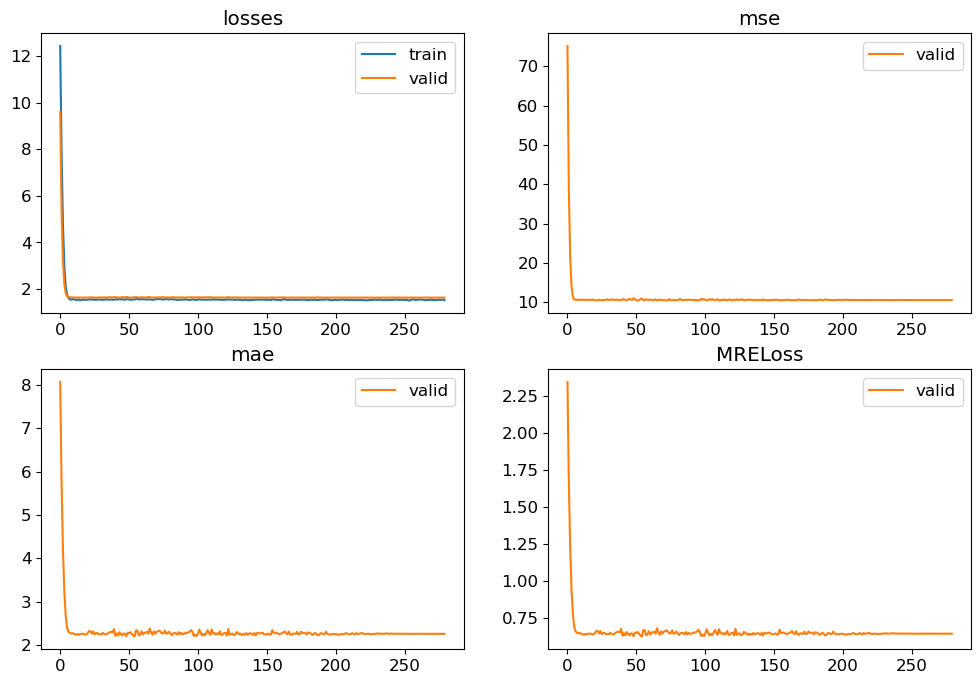

2
using 3 bits
recommended emb size [(494, 52), (492, 51)]
	using emb size: (494, 3)
[0, 17.490381240844727, 14.492369651794434, 117.03855895996094, 10.273032188415527, 3.0983476638793945, '00:00']
[1, 11.651239395141602, 8.348062515258789, 63.35676574707031, 7.409164905548096, 2.235982894897461, '00:00']
[2, 7.100574016571045, 4.779761791229248, 33.39521026611328, 5.304924011230469, 1.6002670526504517, '00:00']
[3, 4.296666622161865, 2.938054084777832, 18.84214973449707, 3.8888156414031982, 1.1709321737289429, '00:00']
[4, 2.789247751235962, 2.0685675144195557, 12.594949722290039, 2.9933922290802, 0.8989695310592651, '00:00']
[5, 2.0522401332855225, 1.7036793231964111, 10.336350440979004, 2.488208532333374, 0.7444936037063599, '00:00']
[6, 1.7278034687042236, 1.576102614402771, 9.714131355285645, 2.2533457279205322, 0.671877384185791, '00:00']
[7, 1.6506893634796143, 1.538732886314392, 9.56529712677002, 2.1734731197357178, 0.646892249584198, '00:00']
[8, 1.6005160808563232, 1.52520513

[73, 1.5688064098358154, 1.516187071800232, 9.562071800231934, 2.0911498069763184, 0.6221997141838074, '00:00']
[74, 1.566543698310852, 1.5263309478759766, 9.558979034423828, 2.126906633377075, 0.6338142156600952, '00:00']
[75, 1.5504528284072876, 1.514496922492981, 9.457386016845703, 2.1214444637298584, 0.6319537162780762, '00:00']
[76, 1.5750457048416138, 1.5519300699234009, 9.472797393798828, 2.249600648880005, 0.6718335747718811, '00:00']
[77, 1.5554207563400269, 1.5109268426895142, 9.443512916564941, 2.1129109859466553, 0.6295284032821655, '00:00']
[78, 1.568354606628418, 1.530360221862793, 9.525338172912598, 2.1536717414855957, 0.6420294642448425, '00:00']
[79, 1.5760598182678223, 1.564760446548462, 9.601373672485352, 2.2507903575897217, 0.6718036532402039, '00:00']
[80, 1.5855592489242554, 1.5089255571365356, 9.357478141784668, 2.1359810829162598, 0.6368640661239624, '00:00']
[81, 1.5656681060791016, 1.5205707550048828, 9.561098098754883, 2.1064183712005615, 0.6271784901618958, 

[146, 1.545796275138855, 1.506543755531311, 9.399685859680176, 2.1120142936706543, 0.629528284072876, '00:00']
[147, 1.5565892457962036, 1.5130671262741089, 9.434233665466309, 2.1239922046661377, 0.6329376697540283, '00:00']
[148, 1.5801554918289185, 1.5176472663879395, 9.384915351867676, 2.156975269317627, 0.6435062289237976, '00:00']
[149, 1.5557390451431274, 1.51255464553833, 9.40485954284668, 2.1319713592529297, 0.6356316804885864, '00:00']
[150, 1.567340612411499, 1.5183688402175903, 9.421649932861328, 2.146287441253662, 0.6402263641357422, '00:00']
[151, 1.5628321170806885, 1.5161176919937134, 9.375056266784668, 2.155219078063965, 0.6429022550582886, '00:00']
[152, 1.5532047748565674, 1.5113780498504639, 9.450621604919434, 2.111301898956299, 0.6292396783828735, '00:00']
[153, 1.557041049003601, 1.5131036043167114, 9.37435531616211, 2.145174741744995, 0.6396311521530151, '00:00']
[154, 1.563846230506897, 1.5148929357528687, 9.49340534210205, 2.1094584465026855, 0.6283915638923645,

[219, 1.5354539155960083, 1.5108983516693115, 9.439699172973633, 2.113750696182251, 0.6299207210540771, '00:00']
[220, 1.5431976318359375, 1.5100433826446533, 9.41215991973877, 2.1204144954681396, 0.6320303678512573, '00:00']
[221, 1.5643359422683716, 1.5111712217330933, 9.405967712402344, 2.1265790462493896, 0.6339716911315918, '00:00']
[222, 1.549111247062683, 1.5104448795318604, 9.411457061767578, 2.1220085620880127, 0.6325545310974121, '00:00']
[223, 1.5550657510757446, 1.5124932527542114, 9.385136604309082, 2.138380765914917, 0.6377555131912231, '00:00']
[224, 1.5516096353530884, 1.5103259086608887, 9.418044090270996, 2.1191329956054688, 0.6316906213760376, '00:00']
[225, 1.5532170534133911, 1.509505033493042, 9.399520874023438, 2.122729778289795, 0.6328365206718445, '00:00']
[226, 1.545064091682434, 1.5096153020858765, 9.430025100708008, 2.1126291751861572, 0.6295698285102844, '00:00']
[227, 1.5586261749267578, 1.5094653367996216, 9.39825439453125, 2.1231846809387207, 0.632933259

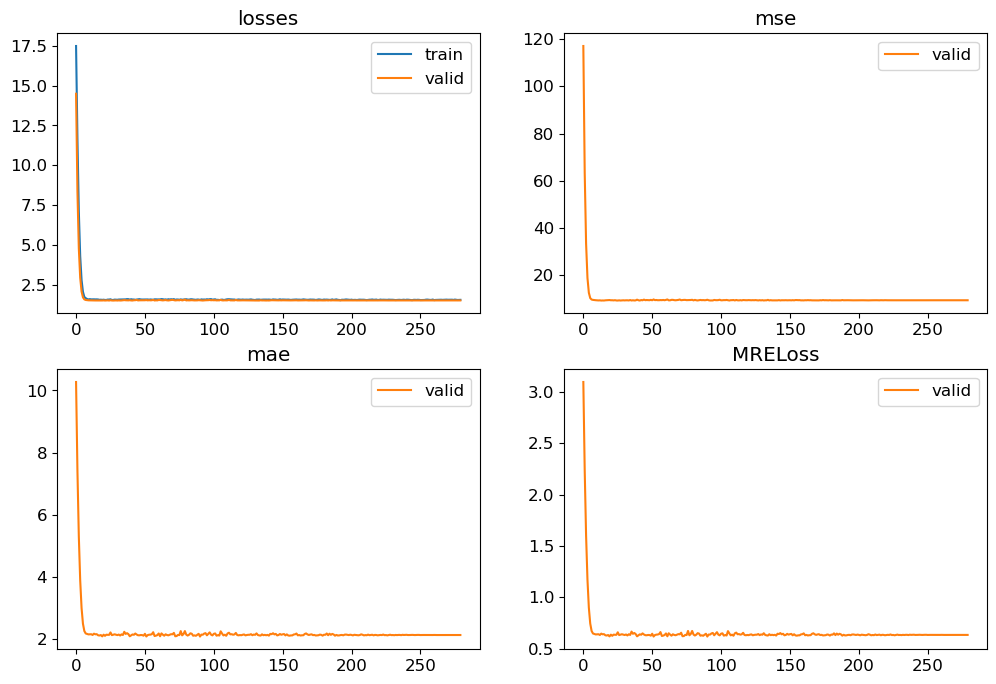

3
using 4 bits
recommended emb size [(493, 52), (493, 52)]
	using emb size: (493, 4)
[0, 14.676249504089355, 11.606059074401855, 92.69719696044922, 9.040827751159668, 2.595935821533203, '00:00']
[1, 9.65487003326416, 6.7334675788879395, 50.38953399658203, 6.561854839324951, 1.8827943801879883, '00:00']
[2, 5.997320652008057, 4.013021469116211, 27.688016891479492, 4.826322555541992, 1.3824666738510132, '00:00']
[3, 3.7557570934295654, 2.614828586578369, 16.730045318603516, 3.662940740585327, 1.0464709997177124, '00:00']
[4, 2.519014358520508, 1.9732729196548462, 12.2527437210083, 2.9192464351654053, 0.8311097621917725, '00:00']
[5, 1.908582091331482, 1.7258317470550537, 10.851390838623047, 2.5090081691741943, 0.7118809223175049, '00:00']
[6, 1.6580941677093506, 1.6661499738693237, 10.648846626281738, 2.35892915725708, 0.6680726408958435, '00:00']
[7, 1.574737548828125, 1.6533184051513672, 10.66165542602539, 2.3052730560302734, 0.6523919701576233, '00:00']
[8, 1.5526772737503052, 1.64763

[73, 1.4564226865768433, 1.5837212800979614, 10.042659759521484, 2.2752645015716553, 0.6438392400741577, '00:00']
[74, 1.4270752668380737, 1.5916188955307007, 10.33720874786377, 2.1944937705993652, 0.6198866963386536, '00:00']
[75, 1.456070899963379, 1.6018197536468506, 10.342184066772461, 2.231475830078125, 0.6306679844856262, '00:00']
[76, 1.454163908958435, 1.6281708478927612, 10.669588088989258, 2.20710825920105, 0.6235688328742981, '00:00']
[77, 1.446628451347351, 1.5876163244247437, 10.013980865478516, 2.2993173599243164, 0.6513537168502808, '00:00']
[78, 1.4644005298614502, 1.5734343528747559, 10.01460075378418, 2.2472989559173584, 0.6355268955230713, '00:00']
[79, 1.4537521600723267, 1.588765025138855, 10.27896785736084, 2.2045512199401855, 0.6231868267059326, '00:00']
[80, 1.4452972412109375, 1.5996298789978027, 10.500954627990723, 2.163167715072632, 0.6105937361717224, '00:00']
[81, 1.4384572505950928, 1.600603461265564, 10.425760269165039, 2.1945927143096924, 0.6200304627418

[146, 1.4279251098632812, 1.5937106609344482, 10.269152641296387, 2.226518154144287, 0.6297726631164551, '00:00']
[147, 1.3913151025772095, 1.5869545936584473, 10.322325706481934, 2.1819705963134766, 0.616357684135437, '00:00']
[148, 1.4117729663848877, 1.5793769359588623, 10.210655212402344, 2.1946463584899902, 0.6203460097312927, '00:00']
[149, 1.3983287811279297, 1.632768154144287, 10.83078384399414, 2.165090322494507, 0.6107665300369263, '00:00']
[150, 1.4160189628601074, 1.5908175706863403, 10.14466667175293, 2.2622973918914795, 0.6403898000717163, '00:00']
[151, 1.4020371437072754, 1.6100834608078003, 10.553969383239746, 2.1811394691467285, 0.6163184642791748, '00:00']
[152, 1.4047907590866089, 1.598649501800537, 10.413595199584961, 2.1916251182556152, 0.6192110776901245, '00:00']
[153, 1.3994951248168945, 1.5805667638778687, 10.239850044250488, 2.188002586364746, 0.6184239387512207, '00:00']
[154, 1.3928756713867188, 1.5974631309509277, 10.371639251708984, 2.203245162963867, 0.6

[219, 1.3768166303634644, 1.5835975408554077, 10.257062911987305, 2.1931815147399902, 0.6198792457580566, '00:00']
[220, 1.3693076372146606, 1.5843671560287476, 10.305055618286133, 2.178128719329834, 0.615401566028595, '00:00']
[221, 1.3836185932159424, 1.582857370376587, 10.224117279052734, 2.2023046016693115, 0.6227174997329712, '00:00']
[222, 1.3775339126586914, 1.5818285942077637, 10.204895973205566, 2.206019639968872, 0.6237099170684814, '00:00']
[223, 1.386087417602539, 1.5887221097946167, 10.299295425415039, 2.1966593265533447, 0.620880663394928, '00:00']
[224, 1.3778741359710693, 1.585129737854004, 10.303030967712402, 2.1817574501037598, 0.6164741516113281, '00:00']
[225, 1.3745648860931396, 1.5873907804489136, 10.338876724243164, 2.1768300533294678, 0.615003228187561, '00:00']
[226, 1.3876354694366455, 1.5824880599975586, 10.222522735595703, 2.2018139362335205, 0.6224842667579651, '00:00']
[227, 1.389146327972412, 1.5826010704040527, 10.26025104522705, 2.188230276107788, 0.618

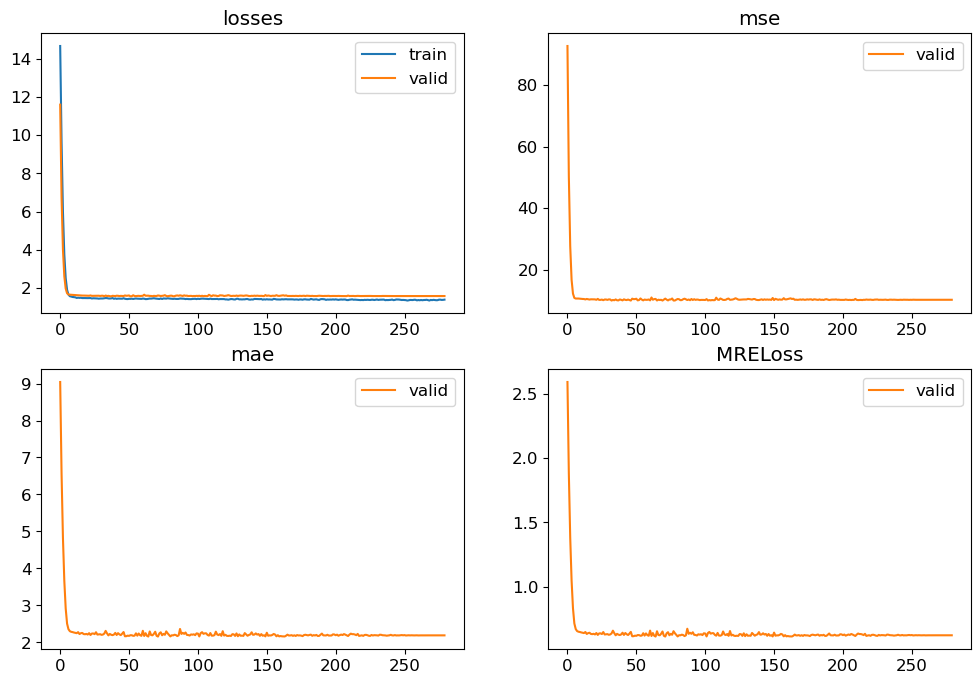

4
using 5 bits
recommended emb size [(494, 52), (493, 52)]
	using emb size: (494, 5)
[0, 11.035295486450195, 8.77367877960205, 67.05474090576172, 7.627708435058594, 2.2980048656463623, '00:00']
[1, 6.952254295349121, 4.884980201721191, 34.2567253112793, 5.39422607421875, 1.6214522123336792, '00:00']
[2, 4.260452747344971, 3.0037081241607666, 19.2797908782959, 3.9901041984558105, 1.1952544450759888, '00:00']
[3, 2.7648861408233643, 2.139940023422241, 13.057463645935059, 3.111633539199829, 0.9268820285797119, '00:00']
[4, 2.0384938716888428, 1.7736436128616333, 10.794329643249512, 2.605353593826294, 0.7713457345962524, '00:00']
[5, 1.7307480573654175, 1.6511561870574951, 10.209433555603027, 2.3749778270721436, 0.7002363801002502, '00:00']
[6, 1.6154118776321411, 1.6175265312194824, 10.098651885986328, 2.294524669647217, 0.6751796007156372, '00:00']
[7, 1.5796648263931274, 1.604692816734314, 10.037043571472168, 2.270383596420288, 0.6677649617195129, '00:00']
[8, 1.567908525466919, 1.59613

[73, 1.3953453302383423, 1.6515648365020752, 10.17038345336914, 2.384605646133423, 0.7050292491912842, '00:00']
[74, 1.3946166038513184, 1.5533244609832764, 9.764759063720703, 2.1766200065612793, 0.6409429311752319, '00:00']
[75, 1.398280382156372, 1.562801718711853, 9.829395294189453, 2.187567949295044, 0.6442911624908447, '00:00']
[76, 1.3815339803695679, 1.5834870338439941, 10.1199369430542, 2.159996271133423, 0.6349923014640808, '00:00']
[77, 1.3752515316009521, 1.5739871263504028, 9.868680953979492, 2.2160234451293945, 0.6523544788360596, '00:00']
[78, 1.3826992511749268, 1.5609370470046997, 9.83527946472168, 2.1811470985412598, 0.64156574010849, '00:00']
[79, 1.389657974243164, 1.5707520246505737, 9.893695831298828, 2.1978540420532227, 0.6459804773330688, '00:00']
[80, 1.3882529735565186, 1.597495436668396, 9.935002326965332, 2.2715089321136475, 0.6711058020591736, '00:00']
[81, 1.3809081315994263, 1.5507078170776367, 9.79588794708252, 2.157499074935913, 0.6345766186714172, '00:0

[146, 1.3204947710037231, 1.5940622091293335, 10.12913990020752, 2.194302558898926, 0.6457204222679138, '00:00']
[147, 1.3151551485061646, 1.5614924430847168, 9.889405250549316, 2.1639487743377686, 0.636168897151947, '00:00']
[148, 1.3124489784240723, 1.589829921722412, 10.147869110107422, 2.1749885082244873, 0.6389366984367371, '00:00']
[149, 1.2905523777008057, 1.576947569847107, 10.13625717163086, 2.131455898284912, 0.6259133815765381, '00:00']
[150, 1.3075960874557495, 1.5970706939697266, 10.370182991027832, 2.1230103969573975, 0.6222804188728333, '00:00']
[151, 1.3154125213623047, 1.582448124885559, 10.196955680847168, 2.1285922527313232, 0.6252805590629578, '00:00']
[152, 1.3100703954696655, 1.5731173753738403, 10.13801097869873, 2.1170194149017334, 0.6214625239372253, '00:00']
[153, 1.3158034086227417, 1.5717767477035522, 9.900398254394531, 2.192690849304199, 0.6463744044303894, '00:00']
[154, 1.3194339275360107, 1.588074803352356, 10.11115550994873, 2.1785387992858887, 0.641065

[219, 1.2395578622817993, 1.573500156402588, 10.001879692077637, 2.163294553756714, 0.6370136737823486, '00:00']
[220, 1.2374356985092163, 1.6022974252700806, 10.153079986572266, 2.210933208465576, 0.6522104144096375, '00:00']
[221, 1.2387182712554932, 1.5872447490692139, 10.044870376586914, 2.1966748237609863, 0.6475085020065308, '00:00']
[222, 1.248612642288208, 1.580334186553955, 10.06464958190918, 2.1658127307891846, 0.6376323699951172, '00:00']
[223, 1.2549437284469604, 1.57413911819458, 10.028703689575195, 2.1557979583740234, 0.6347434520721436, '00:00']
[224, 1.2423936128616333, 1.580397605895996, 10.077628135681152, 2.1616897583007812, 0.6362608075141907, '00:00']
[225, 1.2226470708847046, 1.5773577690124512, 10.064075469970703, 2.155552625656128, 0.6343889236450195, '00:00']
[226, 1.2120628356933594, 1.576939582824707, 10.065406799316406, 2.153062105178833, 0.6337764859199524, '00:00']
[227, 1.2281959056854248, 1.5724341869354248, 10.002693176269531, 2.158637046813965, 0.63573

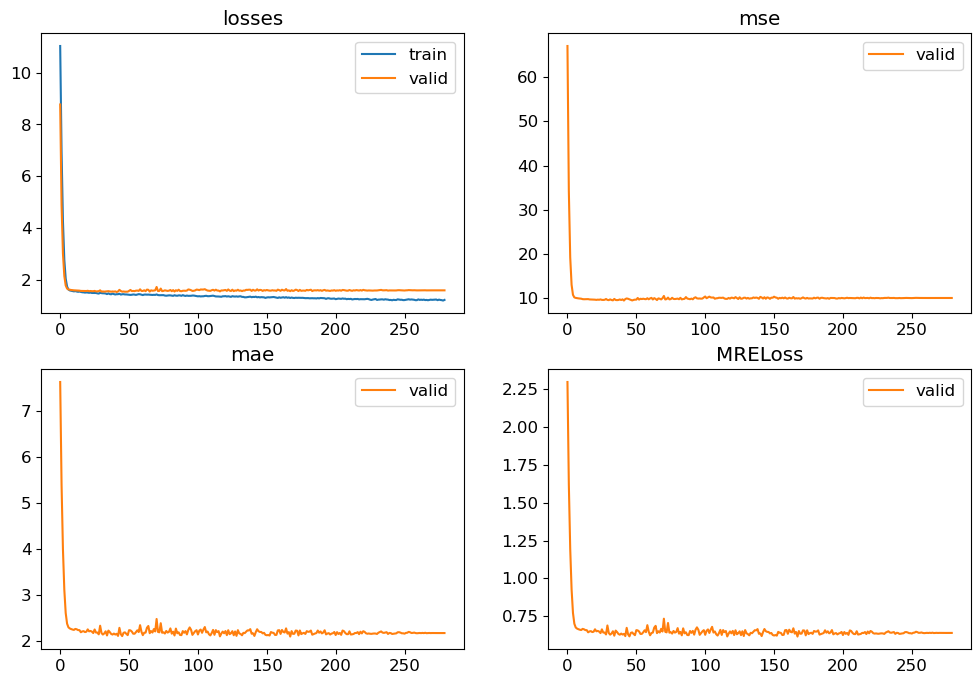

5
using 6 bits
recommended emb size [(494, 52), (493, 52)]
	using emb size: (494, 6)
[0, 11.935699462890625, 9.492414474487305, 73.7573471069336, 8.046602249145508, 2.3518660068511963, '00:00']
[1, 7.690074443817139, 5.362974166870117, 38.579193115234375, 5.721052169799805, 1.6722829341888428, '00:00']
[2, 4.771961212158203, 3.2323660850524902, 21.445663452148438, 4.141169548034668, 1.2086665630340576, '00:00']
[3, 3.0346686840057373, 2.221818685531616, 13.946325302124023, 3.1551198959350586, 0.9190956354141235, '00:00']
[4, 2.1543073654174805, 1.812182068824768, 11.239529609680176, 2.631061553955078, 0.7646993398666382, '00:00']
[5, 1.7789998054504395, 1.6749087572097778, 10.507482528686523, 2.3904430866241455, 0.6935117244720459, '00:00']
[6, 1.6399670839309692, 1.6406718492507935, 10.401748657226562, 2.301851749420166, 0.6672189235687256, '00:00']
[7, 1.583966612815857, 1.6288753747940063, 10.35740852355957, 2.2744128704071045, 0.6590381860733032, '00:00']
[8, 1.5679751634597778, 1.

[73, 1.3027127981185913, 1.6206691265106201, 10.43724250793457, 2.2151811122894287, 0.641049861907959, '00:00']
[74, 1.2739522457122803, 1.6173673868179321, 10.279090881347656, 2.263751268386841, 0.6549537181854248, '00:00']
[75, 1.287681221961975, 1.6048085689544678, 10.38319206237793, 2.1766374111175537, 0.6294326186180115, '00:00']
[76, 1.2684657573699951, 1.642202615737915, 10.565873146057129, 2.246053457260132, 0.6506837010383606, '00:00']
[77, 1.2850656509399414, 1.6924673318862915, 10.879775047302246, 2.321249485015869, 0.6716552376747131, '00:00']
[78, 1.2865500450134277, 1.6390440464019775, 10.397635459899902, 2.301788330078125, 0.6658671498298645, '00:00']
[79, 1.2714958190917969, 1.6706669330596924, 10.626607894897461, 2.331373929977417, 0.6755621433258057, '00:00']
[80, 1.2540204524993896, 1.7040258646011353, 10.835301399230957, 2.378340244293213, 0.6894395351409912, '00:00']
[81, 1.250978708267212, 1.6681586503982544, 10.727380752563477, 2.2842936515808105, 0.6615784764289

[146, 1.108245849609375, 1.7201581001281738, 11.103071212768555, 2.3394689559936523, 0.6776124238967896, '00:00']
[147, 1.1263577938079834, 1.6820814609527588, 10.84328842163086, 2.2923097610473633, 0.6641699075698853, '00:00']
[148, 1.1243911981582642, 1.702468752861023, 10.898571014404297, 2.350778818130493, 0.6806799173355103, '00:00']
[149, 1.1044427156448364, 1.7613312005996704, 11.481242179870605, 2.354029893875122, 0.6813409328460693, '00:00']
[150, 1.0873363018035889, 1.664538025856018, 10.87865924835205, 2.2178690433502197, 0.6407467126846313, '00:00']
[151, 1.1005293130874634, 1.6673129796981812, 10.837791442871094, 2.240417003631592, 0.6483709216117859, '00:00']
[152, 1.1085761785507202, 1.695728063583374, 11.013300895690918, 2.2808101177215576, 0.6604421734809875, '00:00']
[153, 1.1001763343811035, 1.7895563840866089, 11.646946907043457, 2.397003650665283, 0.6942907571792603, '00:00']
[154, 1.098984718322754, 1.6733771562576294, 10.81142520904541, 2.276536226272583, 0.65803

[219, 0.9800552725791931, 1.6828923225402832, 10.941454887390137, 2.260991334915161, 0.6541633009910583, '00:00']
[220, 0.9827747344970703, 1.6809844970703125, 10.949483871459961, 2.249650478363037, 0.6511515378952026, '00:00']
[221, 0.9793673157691956, 1.6984225511550903, 11.007462501525879, 2.2934927940368652, 0.6640846133232117, '00:00']
[222, 0.9842809438705444, 1.6740655899047852, 10.919208526611328, 2.2361457347869873, 0.6468276381492615, '00:00']
[223, 0.9769542813301086, 1.689358115196228, 11.00511646270752, 2.260481834411621, 0.6542736887931824, '00:00']
[224, 0.9858933687210083, 1.6813580989837646, 10.967765808105469, 2.244788885116577, 0.6495351195335388, '00:00']
[225, 0.9739610552787781, 1.6854162216186523, 10.952014923095703, 2.265207529067993, 0.6557941436767578, '00:00']
[226, 0.9655143618583679, 1.6799226999282837, 10.93552017211914, 2.250887393951416, 0.6515228748321533, '00:00']
[227, 0.9743242263793945, 1.7054678201675415, 11.027079582214355, 2.312875270843506, 0.66

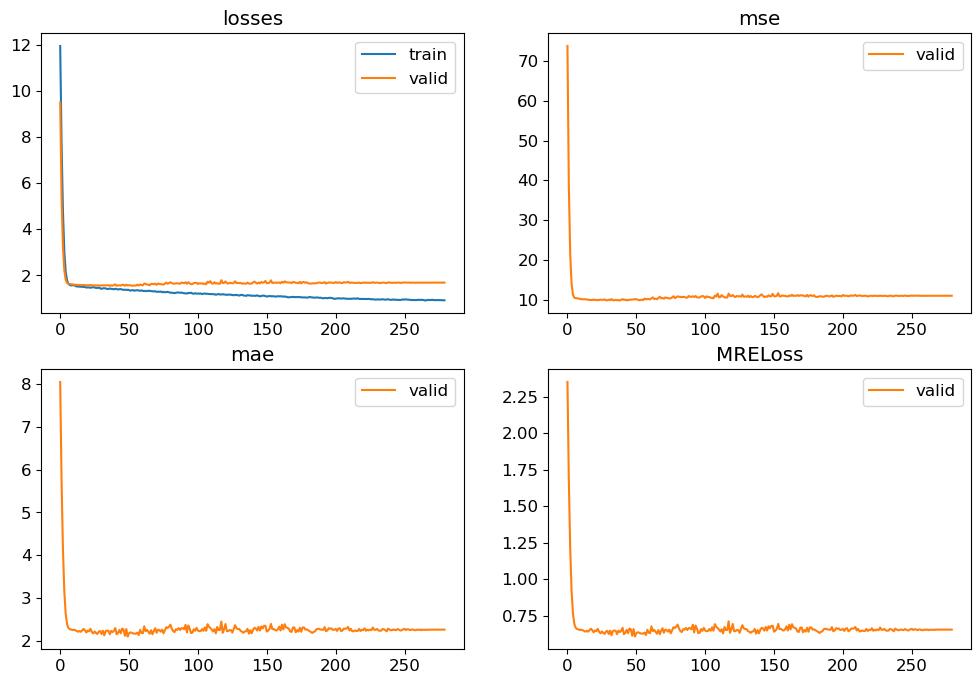

6
using 7 bits
recommended emb size [(494, 52), (492, 51)]
	using emb size: (494, 7)
[0, 11.941004753112793, 9.734827995300293, 75.3608627319336, 8.072339057922363, 2.443047523498535, '00:00']
[1, 7.659919738769531, 5.471407413482666, 39.266273498535156, 5.673028945922852, 1.716422438621521, '00:00']
[2, 4.702212810516357, 3.2815353870391846, 21.634437561035156, 4.111941814422607, 1.242323637008667, '00:00']
[3, 3.0047574043273926, 2.2222323417663574, 13.70523452758789, 3.1413886547088623, 0.946343183517456, '00:00']
[4, 2.1623501777648926, 1.76761794090271, 10.684398651123047, 2.587679147720337, 0.776864767074585, '00:00']
[5, 1.8187828063964844, 1.608900547027588, 9.803792953491211, 2.331345319747925, 0.6983566284179688, '00:00']
[6, 1.6542631387710571, 1.5582890510559082, 9.59141731262207, 2.225376844406128, 0.6657193303108215, '00:00']
[7, 1.6085597276687622, 1.5436756610870361, 9.538084030151367, 2.1919331550598145, 0.6554082632064819, '00:00']
[8, 1.5698267221450806, 1.5345954895

[73, 1.2750422954559326, 1.6280673742294312, 10.066703796386719, 2.3000853061676025, 0.6904410719871521, '00:00']
[74, 1.2699652910232544, 1.6006524562835693, 9.956085205078125, 2.2431640625, 0.6722709536552429, '00:00']
[75, 1.2862162590026855, 1.5816019773483276, 9.798014640808105, 2.2318835258483887, 0.6686673164367676, '00:00']
[76, 1.2738161087036133, 1.5952194929122925, 9.955650329589844, 2.2246487140655518, 0.666282594203949, '00:00']
[77, 1.2554048299789429, 1.5321844816207886, 9.637014389038086, 2.1131784915924072, 0.6316478252410889, '00:00']
[78, 1.2680158615112305, 1.5999242067337036, 10.051291465759277, 2.2092645168304443, 0.6608836650848389, '00:00']
[79, 1.2587050199508667, 1.5859788656234741, 9.865649223327637, 2.2246105670928955, 0.6660154461860657, '00:00']
[80, 1.2532386779785156, 1.5542627573013306, 9.753717422485352, 2.151843786239624, 0.6432122588157654, '00:00']
[81, 1.2455312013626099, 1.603617548942566, 10.1053466796875, 2.201530694961548, 0.6589810848236084, '

[146, 1.0324238538742065, 1.598225474357605, 10.15483283996582, 2.1626904010772705, 0.6474913358688354, '00:00']
[147, 1.0169439315795898, 1.624435544013977, 10.27365493774414, 2.214348554611206, 0.6634111404418945, '00:00']
[148, 1.0011793375015259, 1.6126601696014404, 10.327884674072266, 2.154797077178955, 0.6443021893501282, '00:00']
[149, 1.0146080255508423, 1.7062981128692627, 10.8628568649292, 2.2997019290924072, 0.6889024972915649, '00:00']
[150, 1.033060908317566, 1.598768711090088, 10.190801620483398, 2.152256965637207, 0.6440986394882202, '00:00']
[151, 1.0158255100250244, 1.5920145511627197, 10.149895668029785, 2.144691228866577, 0.6411387920379639, '00:00']
[152, 0.996017336845398, 1.5819913148880005, 10.061511993408203, 2.1400644779205322, 0.6398224234580994, '00:00']
[153, 0.9909473061561584, 1.6569968461990356, 10.47303295135498, 2.260695457458496, 0.6774371862411499, '00:00']
[154, 1.0074474811553955, 1.6273032426834106, 10.322513580322266, 2.2091400623321533, 0.6611688

[218, 0.8652894496917725, 1.6436220407485962, 10.4956693649292, 2.205113410949707, 0.6600611805915833, '00:00']
[219, 0.8680949807167053, 1.6546070575714111, 10.5481595993042, 2.2258658409118652, 0.6664347052574158, '00:00']
[220, 0.8614954352378845, 1.6327544450759888, 10.444314956665039, 2.1856155395507812, 0.6536920070648193, '00:00']
[221, 0.8568446636199951, 1.6358497142791748, 10.461223602294922, 2.1896262168884277, 0.6552528142929077, '00:00']
[222, 0.857040286064148, 1.6346559524536133, 10.445722579956055, 2.190847873687744, 0.655648946762085, '00:00']
[223, 0.8558628559112549, 1.6352877616882324, 10.438737869262695, 2.195127248764038, 0.6571266055107117, '00:00']
[224, 0.8596048355102539, 1.630793809890747, 10.405877113342285, 2.1912801265716553, 0.6557843685150146, '00:00']
[225, 0.8488266468048096, 1.6332550048828125, 10.441152572631836, 2.1882309913635254, 0.6545997262001038, '00:00']
[226, 0.8608287572860718, 1.6400432586669922, 10.469473838806152, 2.2016546726226807, 0.65

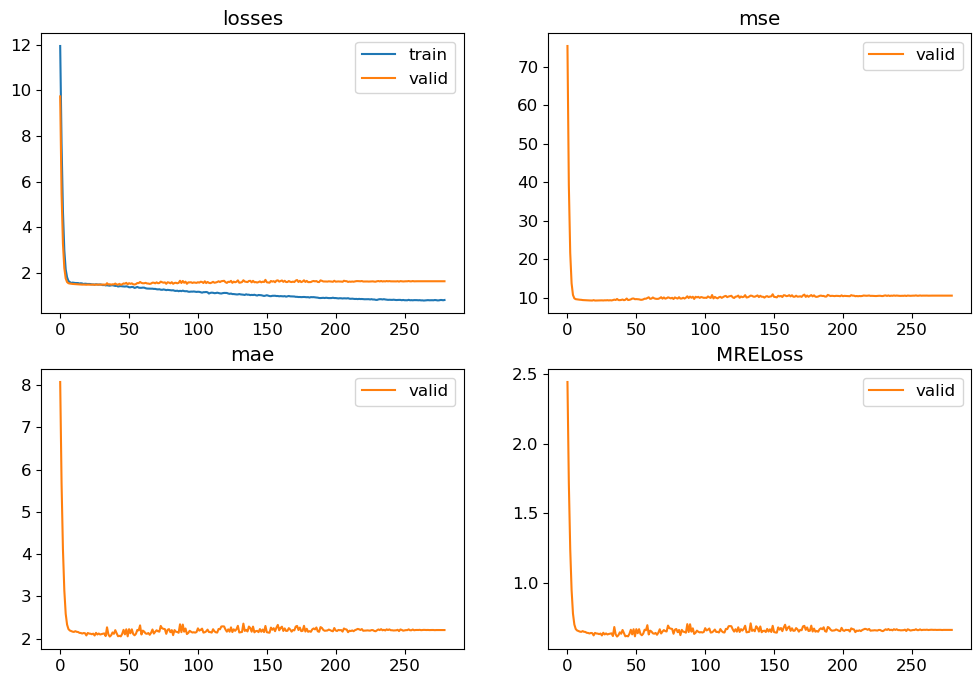

7
using 8 bits
recommended emb size [(494, 52), (493, 52)]
	using emb size: (494, 8)
[0, 13.666362762451172, 11.085978507995605, 87.2716064453125, 8.834418296813965, 2.6209065914154053, '00:00']
[1, 8.815239906311035, 6.199145793914795, 45.344757080078125, 6.233049392700195, 1.8496335744857788, '00:00']
[2, 5.390588283538818, 3.5961875915527344, 24.044700622558594, 4.467843532562256, 1.324130892753601, '00:00']
[3, 3.325491189956665, 2.3370800018310547, 14.455556869506836, 3.349461317062378, 0.9905827045440674, '00:00']
[4, 2.295384645462036, 1.7954212427139282, 10.815418243408203, 2.689493417739868, 0.7931993007659912, '00:00']
[5, 1.8170260190963745, 1.6046340465545654, 9.787357330322266, 2.363903522491455, 0.6954426765441895, '00:00']
[6, 1.639872431755066, 1.5560863018035889, 9.627262115478516, 2.2437801361083984, 0.659288763999939, '00:00']
[7, 1.5935527086257935, 1.5438116788864136, 9.609574317932129, 2.2052204608917236, 0.647615909576416, '00:00']
[8, 1.5819066762924194, 1.53984

[73, 1.1269043684005737, 1.602224588394165, 10.155211448669434, 2.2214114665985107, 0.6518928408622742, '00:00']
[74, 1.1353273391723633, 1.6501702070236206, 10.594795227050781, 2.236567735671997, 0.6563230156898499, '00:00']
[75, 1.117705225944519, 1.6513442993164062, 10.503823280334473, 2.2769277095794678, 0.6677355170249939, '00:00']
[76, 1.137163519859314, 1.5638148784637451, 9.99187183380127, 2.138599157333374, 0.6273640990257263, '00:00']
[77, 1.0927932262420654, 1.6665977239608765, 10.701905250549316, 2.2589423656463623, 0.6626745462417603, '00:00']
[78, 1.1081587076187134, 1.619079828262329, 10.194801330566406, 2.2677717208862305, 0.6662217974662781, '00:00']
[79, 1.0815720558166504, 1.6063374280929565, 10.317256927490234, 2.172914505004883, 0.6384574770927429, '00:00']
[80, 1.0757800340652466, 1.577357292175293, 10.15322494506836, 2.1281044483184814, 0.6244829893112183, '00:00']
[81, 1.0840898752212524, 1.5785272121429443, 9.978863716125488, 2.1964573860168457, 0.6451563239097

[146, 0.8282806873321533, 1.6995383501052856, 11.16214370727539, 2.209641933441162, 0.6481379270553589, '00:00']
[147, 0.8205714225769043, 1.620813012123108, 10.603677749633789, 2.1210944652557373, 0.6227169632911682, '00:00']
[148, 0.8353103399276733, 1.7089111804962158, 11.089041709899902, 2.2693445682525635, 0.6666744947433472, '00:00']
[149, 0.8091910481452942, 1.7101200819015503, 11.151665687561035, 2.2515013217926025, 0.6610596179962158, '00:00']
[150, 0.8175588846206665, 1.7898615598678589, 11.668209075927734, 2.35610294342041, 0.6922673583030701, '00:00']
[151, 0.8187340497970581, 1.6726067066192627, 10.914973258972168, 2.198762893676758, 0.6456769704818726, '00:00']
[152, 0.8199846744537354, 1.791833758354187, 11.774971008300781, 2.3233962059020996, 0.6825963854789734, '00:00']
[153, 0.8206952214241028, 1.6910851001739502, 11.030872344970703, 2.2238900661468506, 0.6533309817314148, '00:00']
[154, 0.8270429372787476, 1.8321291208267212, 11.918746948242188, 2.41994047164917, 0.7

[219, 0.6687485575675964, 1.7085137367248535, 11.138213157653809, 2.2495081424713135, 0.6607696413993835, '00:00']
[220, 0.6627089977264404, 1.6846264600753784, 11.019295692443848, 2.2042899131774902, 0.6474410891532898, '00:00']
[221, 0.6582357883453369, 1.7392268180847168, 11.368826866149902, 2.277968406677246, 0.6692711710929871, '00:00']
[222, 0.6528751850128174, 1.719435691833496, 11.212509155273438, 2.2624170780181885, 0.6646497845649719, '00:00']
[223, 0.6595311760902405, 1.6997907161712646, 11.1124849319458, 2.2270328998565674, 0.6539360880851746, '00:00']
[224, 0.6507062315940857, 1.6447179317474365, 10.741006851196289, 2.1601197719573975, 0.6340193152427673, '00:00']
[225, 0.652736246585846, 1.6504442691802979, 10.793212890625, 2.1619668006896973, 0.6345812678337097, '00:00']
[226, 0.6510907411575317, 1.6833306550979614, 10.983797073364258, 2.2132647037506104, 0.6499454975128174, '00:00']
[227, 0.6588047742843628, 1.684643268585205, 10.989886283874512, 2.215144634246826, 0.65

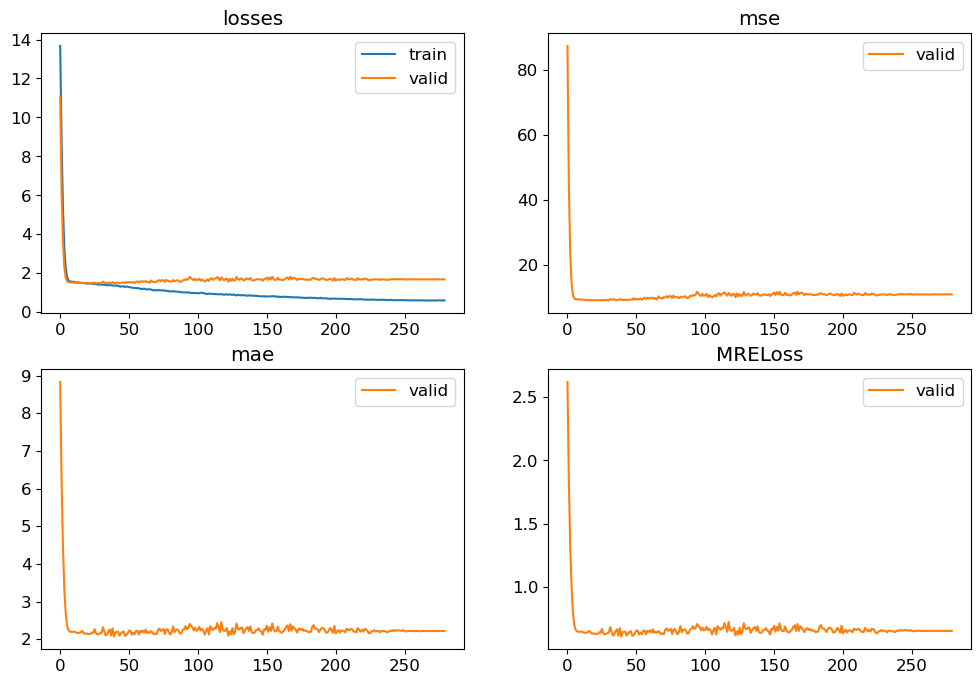

8
using 9 bits
recommended emb size [(493, 52), (493, 52)]
	using emb size: (493, 9)
[0, 10.623324394226074, 8.391558647155762, 63.46673583984375, 7.434227466583252, 2.2720947265625, '00:00']
[1, 6.772929668426514, 4.692381858825684, 32.543983459472656, 5.233248233795166, 1.5977587699890137, '00:00']
[2, 4.1649250984191895, 2.8540420532226562, 18.182838439941406, 3.78659725189209, 1.150842547416687, '00:00']
[3, 2.7394211292266846, 2.016903877258301, 12.249802589416504, 2.912868022918701, 0.8799150586128235, '00:00']
[4, 2.0442707538604736, 1.6638436317443848, 10.045763969421387, 2.4415385723114014, 0.7325194478034973, '00:00']
[5, 1.7571237087249756, 1.5456923246383667, 9.437089920043945, 2.2409844398498535, 0.6688704490661621, '00:00']
[6, 1.6550190448760986, 1.509460687637329, 9.284533500671387, 2.167753219604492, 0.6455636620521545, '00:00']
[7, 1.6120729446411133, 1.4956607818603516, 9.209368705749512, 2.1457319259643555, 0.6385822892189026, '00:00']
[8, 1.587970495223999, 1.48677

[73, 1.1264979839324951, 1.5955792665481567, 9.817530632019043, 2.27526593208313, 0.6820290088653564, '00:00']
[74, 1.094641923904419, 1.5011686086654663, 9.526598930358887, 2.0570335388183594, 0.6094540953636169, '00:00']
[75, 1.0880489349365234, 1.5150656700134277, 9.414318084716797, 2.142143964767456, 0.6373708248138428, '00:00']
[76, 1.087265968322754, 1.5484132766723633, 9.668792724609375, 2.1646013259887695, 0.6461490392684937, '00:00']
[77, 1.082231879234314, 1.5258829593658447, 9.633645057678223, 2.108318567276001, 0.6250202655792236, '00:00']
[78, 1.0762462615966797, 1.5183061361312866, 9.610587120056152, 2.082296371459961, 0.6191638708114624, '00:00']
[79, 1.0706497430801392, 1.5275673866271973, 9.578034400939941, 2.1264431476593018, 0.6330710053443909, '00:00']
[80, 1.052613615989685, 1.5020843744277954, 9.621305465698242, 2.030526876449585, 0.5999488830566406, '00:00']
[81, 1.0547550916671753, 1.523091197013855, 9.601570129394531, 2.105581521987915, 0.6254826188087463, '00:

[146, 0.7483100891113281, 1.7578330039978027, 11.321211814880371, 2.338416576385498, 0.6952352523803711, '00:00']
[147, 0.727088451385498, 1.6488877534866333, 10.640603065490723, 2.1927239894866943, 0.6498085260391235, '00:00']
[148, 0.7562891244888306, 1.6474688053131104, 10.570901870727539, 2.2120649814605713, 0.6559761166572571, '00:00']
[149, 0.7448294758796692, 1.7145134210586548, 11.03725528717041, 2.2844321727752686, 0.6786530613899231, '00:00']
[150, 0.7112783789634705, 1.6814650297164917, 10.759257316589355, 2.266709804534912, 0.6728214621543884, '00:00']
[151, 0.7472844123840332, 1.7356996536254883, 11.14250373840332, 2.325329065322876, 0.6904993653297424, '00:00']
[152, 0.7226739525794983, 1.6080487966537476, 10.352984428405762, 2.147535800933838, 0.6363890767097473, '00:00']
[153, 0.7163382768630981, 1.6235657930374146, 10.494163513183594, 2.1584901809692383, 0.6379438638687134, '00:00']
[154, 0.7245113849639893, 1.6242754459381104, 10.496468544006348, 2.1608471870422363, 0

[218, 0.5526602268218994, 1.716661810874939, 11.183958053588867, 2.2387523651123047, 0.6647403836250305, '00:00']
[219, 0.5624029040336609, 1.7028474807739258, 11.077956199645996, 2.226414442062378, 0.6611687541007996, '00:00']
[220, 0.5467509627342224, 1.6826263666152954, 10.960857391357422, 2.1954174041748047, 0.6517115831375122, '00:00']
[221, 0.5473122000694275, 1.686034917831421, 10.95581340789795, 2.208491563796997, 0.6560595631599426, '00:00']
[222, 0.5482228398323059, 1.6874579191207886, 10.978863716125488, 2.20379638671875, 0.6550793647766113, '00:00']
[223, 0.5469498634338379, 1.6773916482925415, 10.939142227172852, 2.185687303543091, 0.6483084559440613, '00:00']
[224, 0.5321894288063049, 1.694177269935608, 11.036272048950195, 2.2102341651916504, 0.6561666131019592, '00:00']
[225, 0.5351119637489319, 1.6732618808746338, 10.889549255371094, 2.186457395553589, 0.6492299437522888, '00:00']
[226, 0.5391538739204407, 1.6783065795898438, 10.916000366210938, 2.194483995437622, 0.651

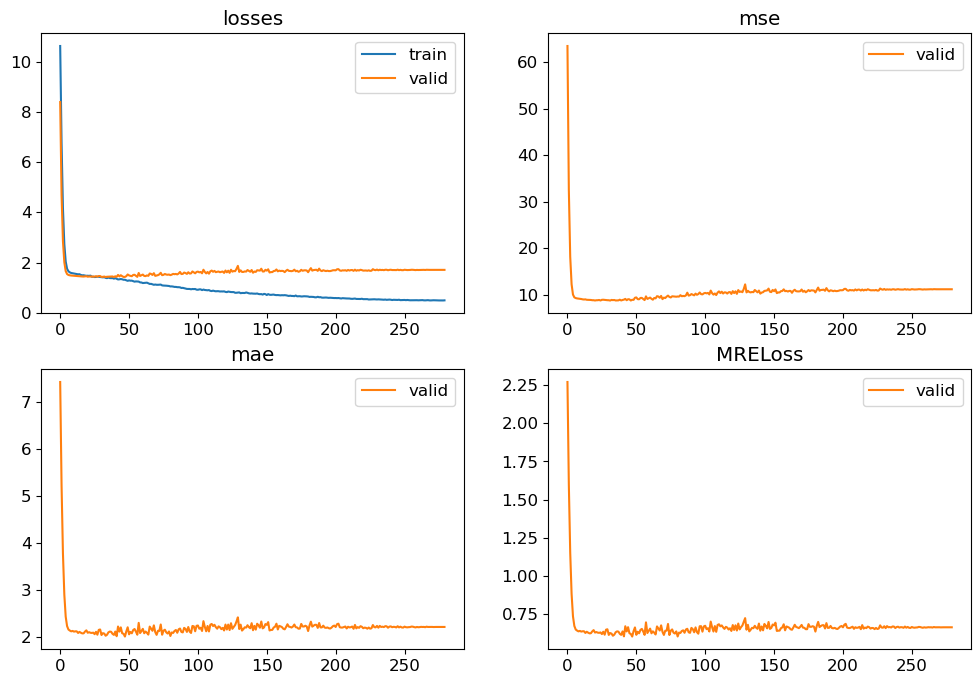

9


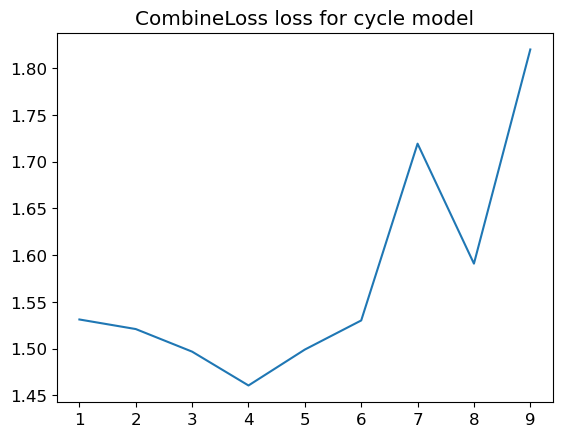

[1.531199336051941, 1.5209541320800781, 1.4967801570892334, 1.4605696201324463, 1.4990148544311523, 1.5301520824432373, 1.7193577289581299, 1.5909665822982788, 1.8201478719711304]


In [13]:
plot_bits_to_loss(10, loss_function, "cycle", alpha,
                  num_epochs, train_pct, eval_loss, "CombineLoss", lg_N=5)
# def plot_bits_to_loss(max_bits, trainloss, model_type, alpha, num_epochs, train_pct, eval_loss, lossname, lg_N=4):


using 1 bits
recommended emb size [(460, 50), (464, 50)]
	using emb size: (464, 1)
[0, 5.875021457672119, 5.216911315917969, 38.508174896240234, 5.731598854064941, 1.5178824663162231, '00:00']
[1, 5.101844787597656, 4.083675384521484, 29.1787109375, 4.89025354385376, 1.295338749885559, '00:00']
[2, 4.336675643920898, 3.1402578353881836, 21.600685119628906, 4.110497951507568, 1.0890998840332031, '00:00']
[3, 3.6025850772857666, 2.3892016410827637, 15.721648216247559, 3.425448179244995, 0.9078184366226196, '00:00']
[4, 2.9374935626983643, 1.8178468942642212, 11.367608070373535, 2.8549892902374268, 0.7567622661590576, '00:00']
[5, 2.361976385116577, 1.4099876880645752, 8.361144065856934, 2.4061708450317383, 0.6376370191574097, '00:00']
[6, 1.8980560302734375, 1.1447688341140747, 6.46099853515625, 2.0919101238250732, 0.5540765523910522, '00:00']
[7, 1.5495178699493408, 0.994767427444458, 5.40447998046875, 1.9071812629699707, 0.5047991871833801, '00:00']
[8, 1.2938066720962524, 0.9198354482

[73, 0.8329653143882751, 0.8718796968460083, 4.620680809020996, 1.7223591804504395, 0.45534631609916687, '00:00']
[74, 0.8345402479171753, 0.8726522922515869, 4.604947090148926, 1.7319543361663818, 0.4579528272151947, '00:00']
[75, 0.8363702893257141, 0.8685408234596252, 4.592901229858398, 1.7195630073547363, 0.4547230303287506, '00:00']
[76, 0.8381000757217407, 0.873913049697876, 4.627468585968018, 1.7281256914138794, 0.45685118436813354, '00:00']
[77, 0.840619683265686, 0.8786763548851013, 4.649902820587158, 1.7378743886947632, 0.4596511423587799, '00:00']
[78, 0.8409497737884521, 0.8719934225082397, 4.6031413078308105, 1.7297990322113037, 0.4574214816093445, '00:00']
[79, 0.8402711153030396, 0.8703280687332153, 4.6057538986206055, 1.7224513292312622, 0.45528075098991394, '00:00']
[80, 0.8389391303062439, 0.876611590385437, 4.641346454620361, 1.7336125373840332, 0.458307683467865, '00:00']
[81, 0.8403928279876709, 0.8716102838516235, 4.6168599128723145, 1.7229173183441162, 0.45547145

[146, 0.8363675475120544, 0.8720988035202026, 4.603536128997803, 1.730354905128479, 0.4574945867061615, '00:00']
[147, 0.8329592943191528, 0.867141604423523, 4.590395927429199, 1.7148069143295288, 0.45344653725624084, '00:00']
[148, 0.8373035788536072, 0.87459796667099, 4.631798267364502, 1.728386402130127, 0.45713135600090027, '00:00']
[149, 0.8349459171295166, 0.8670842051506042, 4.583070755004883, 1.7174326181411743, 0.454196959733963, '00:00']
[150, 0.8325361609458923, 0.8709825277328491, 4.613094806671143, 1.7215454578399658, 0.45519229769706726, '00:00']
[151, 0.8327306509017944, 0.8668490648269653, 4.578006267547607, 1.7187268733978271, 0.4544983208179474, '00:00']
[152, 0.831865668296814, 0.865162193775177, 4.564945220947266, 1.7172495126724243, 0.4540751874446869, '00:00']
[153, 0.8338099718093872, 0.8664301633834839, 4.585088729858398, 1.7142590284347534, 0.4532458484172821, '00:00']
[154, 0.8343519568443298, 0.8668571710586548, 4.5690531730651855, 1.7227851152420044, 0.45550

[218, 0.8315621018409729, 0.8674383759498596, 4.5934977531433105, 1.7150001525878906, 0.4534318745136261, '00:00']
[219, 0.830405592918396, 0.8678702712059021, 4.5966572761535645, 1.7154000997543335, 0.45356065034866333, '00:00']
[220, 0.8291579484939575, 0.8667484521865845, 4.586018085479736, 1.7151166200637817, 0.4534962475299835, '00:00']
[221, 0.8293689489364624, 0.86667799949646, 4.585384845733643, 1.7150442600250244, 0.45348837971687317, '00:00']
[222, 0.8300915360450745, 0.8677218556404114, 4.594446659088135, 1.7157315015792847, 0.45364126563072205, '00:00']
[223, 0.8258934020996094, 0.8670889139175415, 4.591272354125977, 1.714313268661499, 0.45329079031944275, '00:00']
[224, 0.8273941874504089, 0.8667978644371033, 4.588802337646484, 1.7142306566238403, 0.45324182510375977, '00:00']
[225, 0.8287524580955505, 0.8687521815299988, 4.599503040313721, 1.7180778980255127, 0.4542243778705597, '00:00']
[226, 0.829459547996521, 0.867560625076294, 4.590238094329834, 1.7168534994125366, 0.

../aten/src/ATen/native/cuda/Indexing.cu:1141: indexSelectLargeIndex: block: [3,0,0], thread: [96,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1141: indexSelectLargeIndex: block: [3,0,0], thread: [97,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1141: indexSelectLargeIndex: block: [3,0,0], thread: [98,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1141: indexSelectLargeIndex: block: [3,0,0], thread: [99,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1141: indexSelectLargeIndex: block: [3,0,0], thread: [100,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1141: indexSelectLargeIndex: block: [3,0,0], thread: [101,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1141: indexSelectLargeIndex: block: [3,0,0], thread

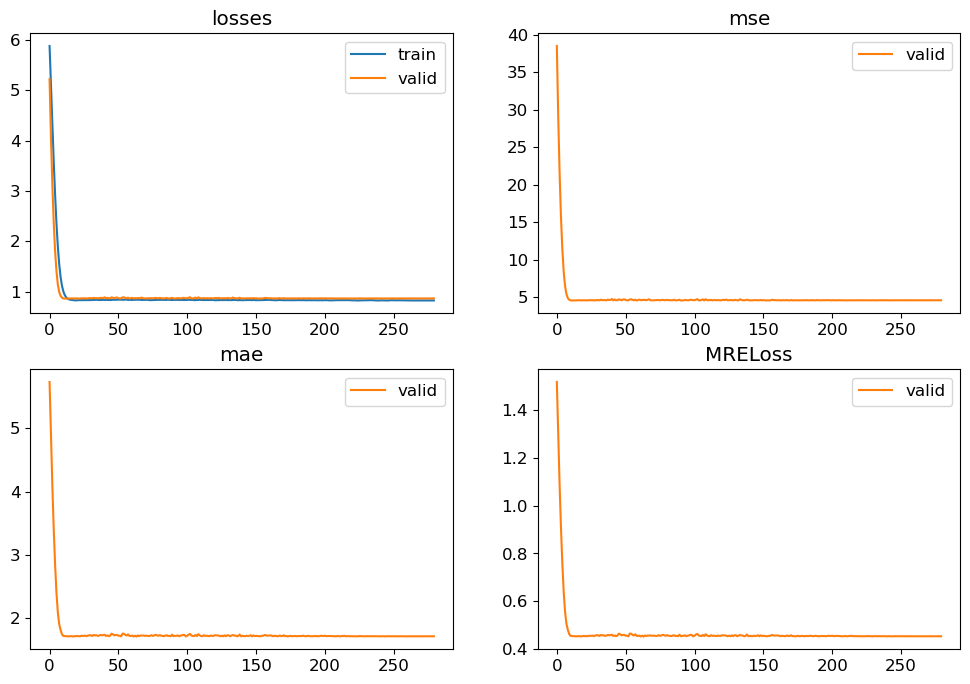

1


RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasLtMatmul( ltHandle, computeDesc.descriptor(), &alpha_val, mat1_ptr, Adesc.descriptor(), mat2_ptr, Bdesc.descriptor(), &beta_val, result_ptr, Cdesc.descriptor(), result_ptr, Cdesc.descriptor(), &heuristicResult.algo, workspace.data_ptr(), workspaceSize, at::cuda::getCurrentCUDAStream())`

In [14]:
plot_bits_to_loss(10, loss_function, "tree", alpha,
                  num_epochs, train_pct, eval_loss, "MSE", lg_N=5)